In [45]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import csr_matrix



In [46]:
# load in the data
genotypes = pd.read_csv('tomatoes/more_genotypes.txt', index_col=0)
phenotype = pd.read_csv('tomatoes/phenodata_BLUP_2012.txt', sep='\t', index_col='ID')

In [47]:
print("Data preview:")
genotypes.head()


Data preview:


,IIT9210,IIT9211,IIT8604,IIT9212,IIT9213,IIT9215,IIT8613,IIT9218,IIT9219,IIT8662,...,solcap_snp_sl_31405,solcap_snp_sl_31403,SGN.U567105_snp715_solcap_snp_sl_31389,solcap_snp_sl_31373,solcap_snp_sl_6526,CL009067.0206,solcap_snp_sl_31353,solcap_snp_sl_6524,solcap_snp_sl_31342,solcap_snp_sl_31304_1
SYNAGAD_001,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SYNAGAD_002,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
SYNAGAD_003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
SYNAGAD_004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
SYNAGAD_005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0


In [48]:
print("Data preview:")
phenotype.head()

Data preview:


,AVVIG97,AVGROW97,FLEAR,FRDA1,FREAR,AVCFWHA,AVNCFWH,AVYTFNW
ID,,,,,,,,
SYNAGAD_001,2.707203,-8.340000e-08,6.835274,7.846930,2.264951,1.176012,1.095265,1.180196
SYNAGAD_002,0.020656,6.180000e-08,-0.261801,-3.019323,-2.585154,-0.574425,-0.347104,-0.509311
SYNAGAD_003,-1.853680,9.900000e-08,-5.838074,-3.824231,0.772611,-0.698021,-0.423512,-0.652196
SYNAGAD_004,-1.478813,1.210000e-07,-5.838074,-2.616870,1.891866,-0.832750,-0.750902,-0.856130
SYNAGAD_005,-2.103591,7.320000e-08,-6.345008,-7.178013,-1.963346,-0.903440,-0.901180,-0.917480


In [49]:
# 'genotypes' and 'phenotype' are already loaded and aligned by their indices
# now we check for missing data
imputer = SimpleImputer(strategy='median')
genotypes_imputed = pd.DataFrame(imputer.fit_transform(genotypes), columns=genotypes.columns)
phenotype_imputed = pd.DataFrame(imputer.fit_transform(phenotype), columns=phenotype.columns)

# Scale the data
scaler = StandardScaler()
genotypes_scaled = pd.DataFrame(scaler.fit_transform(genotypes_imputed), columns=genotypes.columns)

# Check for any remaining NaNs or infinities
genotypes_scaled = genotypes_scaled.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
phenotype_scaled = pd.DataFrame(scaler.fit_transform(phenotype_imputed), columns=phenotype.columns)

In [50]:
genotypes_scaled.head()

,IIT9210,IIT9211,IIT8604,IIT9212,IIT9213,IIT9215,IIT8613,IIT9218,IIT9219,IIT8662,...,solcap_snp_sl_31405,solcap_snp_sl_31403,SGN.U567105_snp715_solcap_snp_sl_31389,solcap_snp_sl_31373,solcap_snp_sl_6526,CL009067.0206,solcap_snp_sl_31353,solcap_snp_sl_6524,solcap_snp_sl_31342,solcap_snp_sl_31304_1
0,2.229530,2.250470,-0.53497,-1.012472,-1.015832,1.060278,-0.39052,-0.75003,-0.705744,1.512674,...,-0.582757,-0.531388,-0.584266,-0.866320,-0.353153,-0.542975,-0.601388,-0.394939,-0.605429,-0.474861
1,2.229530,2.250470,-0.53497,-1.012472,-1.015832,1.060278,-0.39052,-0.75003,-0.705744,-0.666475,...,-0.582757,-0.531388,-0.584266,1.174969,-0.353153,-0.542975,-0.601388,-0.394939,-0.605429,-0.474861
2,-0.468155,-0.466902,-0.53497,-1.012472,-1.015832,-0.956329,-0.39052,-0.75003,-0.705744,-0.666475,...,1.756309,-0.531388,1.777143,1.174969,-0.353153,-0.542975,1.716546,-0.394939,1.712726,-0.474861
3,-0.468155,-0.466902,-0.53497,-1.012472,-1.015832,-0.956329,-0.39052,-0.75003,-0.705744,-0.666475,...,1.756309,2.067500,1.777143,1.174969,-0.353153,-0.542975,1.716546,-0.394939,1.712726,2.182535
4,-0.468155,-0.466902,-0.53497,-1.012472,-1.015832,-0.956329,-0.39052,-0.75003,-0.705744,-0.666475,...,1.756309,2.067500,1.777143,1.174969,-0.353153,-0.542975,1.716546,-0.394939,1.712726,2.182535


In [51]:
phenotype_scaled.head()

,AVVIG97,AVGROW97,FLEAR,FRDA1,FREAR,AVCFWHA,AVNCFWH,AVYTFNW
0,1.608862,-1.241663,1.509307,1.553127,0.852062,1.930903,1.846739,1.929939
1,-0.015832,0.953858,-0.085743,-0.636010,-1.004047,-1.001716,-0.635264,-0.889357
2,-1.149340,1.516346,-1.338996,-0.798168,0.280952,-1.208785,-0.766745,-1.127791
3,-0.922638,1.849001,-1.338996,-0.554931,0.709285,-1.434505,-1.330111,-1.468098
4,-1.300474,1.126233,-1.452928,-1.473827,-0.766085,-1.552936,-1.588706,-1.570473


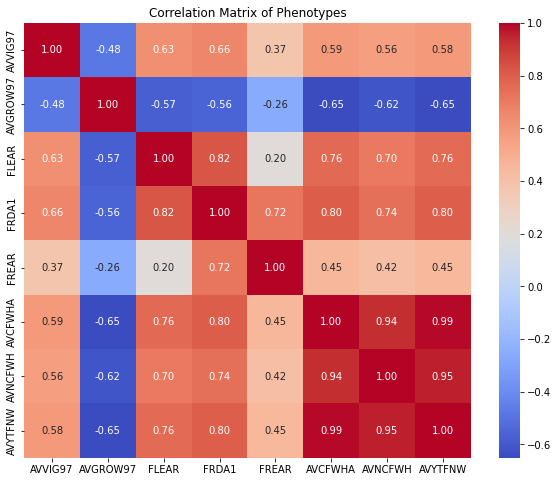

In [52]:
# Assuming 'phenotypes' is your DataFrame containing the phenotype data
correlation_matrix = phenotype_scaled.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Phenotypes')
plt.show()

##### AVGROW97 (plant growth (plant stem elongation between 90 and 97 days after sowing: GROW97)) seems to have consistently moderate negative correlations with most other traits. This could make it interesting if we are looking for unique genetic factors that specifically influence growth, independent of other factors.

In [53]:
# Extract the AVGROW97 column from the phenotype dataframe
y = phenotype_scaled['AVGROW97']
# Construct X from the genotype dataframe
X = genotypes_scaled

# Determine the number of samples (rows) and features (columns)
num_samples, num_features = X.shape

print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

Number of samples: 291
Number of features: 9381


### now after preprocessing the data we want to access the genetic structure and calculate the kinship matrix 

##### Principal Component Analysis (PCA) to Assess Genetic Structure

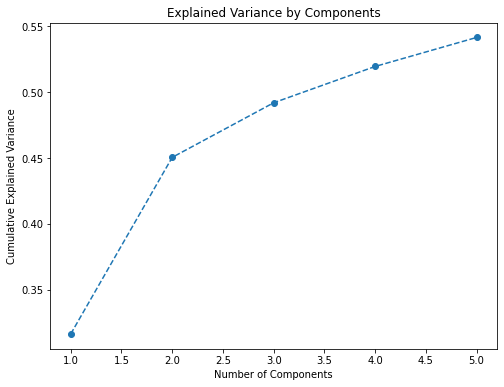

In [54]:
# Perform PCA on the genotype data
pca = PCA(n_components=5)
principal_components = pca.fit_transform(genotypes_scaled)

# Plot the variance explained by each principal component
plt.figure(figsize=(8, 6))
# Adjust the x-range to match the number of PCA components
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### Select the number of components to use based on the PCA results


In [55]:
# Select components that explain at least 80% of the variance
cum_var_explained = np.cumsum(pca.explained_variance_ratio_)
num_components = np.where(cum_var_explained > 0.8)[0][0] + 1 if np.any(cum_var_explained > 0.8) else len(cum_var_explained)
pca_selected = principal_components[:, :num_components]


### Kinship Matrix Calculation

In [56]:
# Calculate the kinship matrix from PCA components
distances = euclidean_distances(principal_components)
# Threshold distances to create a sparser kinship matrix
threshold_distance = np.percentile(distances, 50)  # Keep distances below the 50th percentile
kinship_matrix = np.where(distances < threshold_distance, 1 - distances / np.max(distances), 0)
# If the exog_re (kinship matrix) can be made sparse,
# it might reduce memory usage significantly.
# Convert the kinship matrix to a sparse matrix
kinship_matrix_sparse = csr_matrix(kinship_matrix)

# Ensure kinship_matrix is 2D and sparse
kinship_matrix_sparse = csr_matrix(kinship_matrix)
if kinship_matrix_sparse.ndim != 2:
    raise ValueError("Kinship matrix must be 2-dimensional")

### Conduct GWAS

Instead of fitting the model for all SNPs at once, consider breaking the dataset into smaller batches and processing each separately.

In [58]:
batch_size = 100
kinship_matrix_dense = kinship_matrix_sparse.toarray()
p_values = []
for i in range(0, genotypes_scaled.shape[1], batch_size):
    end = min(i + batch_size, genotypes_scaled.shape[1])
    for j in range(i, end):
        X = sm.add_constant(genotypes_scaled.iloc[:, j])  # Add constant to the model
        pca_df = pd.DataFrame(pca_selected, columns=[f'PC_{j}' for j in range(pca_selected.shape[1])])
        covariates = pd.concat([X, pca_df], axis=1)
        # Check if covariates dataframe is correct
        if np.any(pd.isnull(y)):
            raise ValueError("y contains NaN or infinite values")
        print("y shape:", y.shape)
        if covariates.isnull().any().any():
            raise ValueError("Covariates DataFrame contains NaN values")
        print("Covariates shape:", covariates.shape)
        groups = pd.Series(np.ones(len(y)))
        if len(groups) != len(y):
            raise ValueError("Mismatch in length of groups and y")
        print("Groups shape:", groups.shape)
        print("kinship matrix shape",kinship_matrix_dense.shape)

        model = MixedLM(y, covariates, groups=pd.Series(np.ones(len(y))), exog_re=kinship_matrix_dense)
        result = model.fit(method='cg')
        p_values.append(result.pvalues[1])  # Store the p-value for the SNP


y shape: (291,)
Covariates shape: (291, 7)
Groups shape: (291,)
kinship matrix shape (291, 291)


MemoryError: Unable to allocate 13.5 GiB for an array with shape (42493, 42493) and data type float64

#### Result Analysis and Visualization

In [ ]:
# After computing the p-values for each SNP, 
# analyze and visualize the results to identify significant associations.
# Convert p-values to a numpy array for easy handling
p_values_array = np.array(p_values)

# Plotting the GWAS results: Manhattan Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(p_values_array)), -np.log10(p_values_array), c='b', alpha=0.5, marker='o')
plt.axhline(-np.log10(0.05 / genotypes_scaled.shape[1]), color='r', linestyle='--')  # Bonferroni correction
plt.xlabel('SNP Index')
plt.ylabel('-log10(p-value)')
plt.title('GWAS Manhattan Plot')
plt.show()


### load these features back into a Python session for analysis, we can use numpy.loadtxt():

In [ ]:
selected_features_lasso = np.loadtxt("selected_features_lasso.txt", dtype=int)
selected_features_enet = np.loadtxt("selected_features_enet.txt", dtype=int)
selected_features_svm = np.loadtxt("selected_features_svm.txt", dtype=int)
selected_features_rf = np.loadtxt("selected_features_rf.txt", dtype=int)
selected_features_rfe = np.loadtxt("selected_features_rfe.txt", dtype=int)
selected_features_gbm = np.loadtxt("selected_features_gbm.txt", dtype=int)
selected_features_xgb = np.loadtxt("selected_features_xgb.txt", dtype=int)